# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

# [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle


In [1]:
data = pd.read_csv('Reviews.csv')
print (data.head())
print(data.shape)

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

## [2] Data Cleaning: Deduplication and Nan features

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [2]:
#checking for Nan values in data. True indicates Nan values are present along the columns
data.isnull().any()

Id                        False
ProductId                 False
UserId                    False
ProfileName                True
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                    True
Text                      False
dtype: bool

In [18]:
# checking for Nan values along 'profilename' column
#data[data['ProfileName'].isnull()].head()

In [19]:
# checking for Nan values along 'summary' column
#data[data['Summary'].isnull()]

In [5]:
#Dropping Nan values
data = data.dropna()

In [6]:
#printing shape of data after dropping Nan values
print (data.shape)

(568411, 10)


In [7]:
#Review score should lie between 1 to 5
#Returns True if all the scores lie between 1 to 5(inclusive)
list1 = data['Score'].map(lambda x: True if x in [1,2,3,4,5] else False)
list1.all()

True

In [8]:
filtered_data = data.loc[data['Score']!=3]
print (filtered_data.head())
print (filtered_data.shape)

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [9]:
#mapping positive(>3) and negative(<3) reviews based on scores of the data.
pos_negative = filtered_data['Score'].map(lambda x: 'positive' if int (x) >3 else 'negative')
filtered_data['Score'] = pos_negative
print ('shape of filtered_data')
print (filtered_data.shape)
print (filtered_data.head())


shape of filtered_data
(525773, 10)
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  

C:\Users\Lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
#arranging data with increasing productid
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort')

In [20]:
#finding the duplicates in our data
#If the same person gives for the same product at the same time we call it as suplicates
#sorted_data.loc[sorted_data.duplicated(["UserId","ProfileName","Time","Text"],keep = False),:]

In [12]:
#counting number of duplicates present in our data
sorted_data.duplicated(["UserId","ProfileName","Time","Text"]).sum()

161612

In [13]:
#dropping all duplicates keeping the first one
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace = False)
final.shape

(364161, 10)

In [14]:
#helpfulness numerator denotes number of people who found the review helpful
#helpfulness denominator denotes number of people who indicated whether or not the review helpful
#so, helpfulness numerator should be less than denominator
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#final shape of data after preprocessing
final.shape

(364159, 10)

In [16]:
#counting number of positive and negative reviews present
final['Score'].value_counts()

positive    307054
negative     57105
Name: Score, dtype: int64

#  [3] Preprocessing

# [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [18]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
not_words = re.findall(r'\w*n[\'|o]t',str (stop)) #finding NOT words in stop words
not_words.append('n\'t')
not_words.append('no')
print (not_words)
stop_words = stop - set (not_words)  #removing  NOT words from stop words
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r'\w*n[\'|o]t', "not", phrase)
    # general
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
def cleanhtmlpunc(sentence): #function to clean the word of any html-tags
    clean = re.compile('<.*?>')
    clean = re.sub(clean, ' ', sentence)
    clean = re.sub(r"(http|www)\S+", "", clean)
    clean = re.sub(r"\S+com", "",clean)
    #clean = re.sub(r"\(\w+\)","",clean)
    clean = re.sub(r"\."," ",clean)
    cleaned = re.sub(r'[?+|!+|\'+|"+|#+|:+]',r' ',clean)
    cleantext = re.sub(r'[\.+|,+|)+|(+|\+|/+]',r' ',cleaned)
    return cleantext
#def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
   # return  cleaned
print('************************************')                 
print(stop_words)

["won't", 'not', "needn't", "don't", "mustn't", "haven't", "aren't", "shan't", "wouldn't", "mightn't", "isn't", "wasn't", "couldn't", "weren't", "hadn't", "didn't", "hasn't", "shouldn't", "doesn't", "n't"]
************************************
{'his', 'who', "you've", 'don', 'o', 'your', 'mustn', 'my', 'other', 'both', 'out', 'wasn', "should've", 'where', 'whom', 'most', 'aren', 'now', 'its', 'that', 'are', 'didn', 'him', 'll', 'has', 'any', 'ours', 'having', 's', 'hadn', 'haven', 'for', 'ain', 'very', 'own', 'or', 'y', 'shan', 'only', 'what', 'because', 'after', 'our', 'wouldn', 'before', 'an', 'at', 'then', 'does', 'being', 'by', 'about', 'while', 'how', 'had', 'from', 'their', 'it', 'myself', 'there', 'was', 'in', 'be', 'each', 'weren', 'once', 've', 'hasn', "you're", 'itself', 'those', 't', 'with', "she's", 'she', 'here', 'such', 'few', 'do', 'm', 'will', 'to', 'this', 'shouldn', 'nor', 'have', 'he', 'did', 'as', 'when', 'her', 'between', 'up', 'ma', 're', 'himself', 'were', 'throug

In [19]:
def cleanedtext(reviews):
    str1=' '
    final_string=[]
    s=''
    for sent in reviews:
        filtered_sentence=[]    
        sent=cleanhtmlpunc(decontracted(sent)) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in w.split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if((cleaned_words.lower() not in stop_words)):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                    else:
                        continue
                else:
                    continue 
        str1 = b" ".join(filtered_sentence) #final string of cleaned words for reviews
        final_string.append(str1)
    return final_string

In [20]:
final_data['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final_data.head() #below the processed review can be seen in the CleanedText Column 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
370049,370050,B001G8W7SI,A3TT44LPX0926Z,"J ""J""",0,0,positive,1330905600,excellent product--wish it was cheaper!,great product but wish it could be found a bit...,b'great product wish could found bit cheaperse...
268423,268424,B0000GIVAU,A302B2MHY8R5PD,izzy,0,0,positive,1341360000,Nothing compares,"Honestly, I used to hate mineral water until I...",b'honest use hate miner water tri everi singl ...
449524,449525,B003P9WU6A,ADD2FROEIZCPK,Matthr,1,1,positive,1296604800,Love it! Leaves cat's coat beautiful!,I have been using this product for a while now...,b'use product cat coat shini healthi greatest ...
512616,512617,B003RM9SA6,A37700CWJ4XD69,Macoma,6,6,positive,1290988800,Best Vanilla We Could Find,We have friends and family that bring back van...,b'friend famili bring back vanilla mexico far ...
368187,368188,B000SAPXPY,A3MQ68M8KRBUQH,Claudia,2,2,positive,1340928000,Excellent flavor,"I'm a big fan of good, strong British tea like...",b'big fan good strong british tea like tip tol...


# Applying Random Forest

# [4.1] Random Forest on BOW,<font color='red'> SET 1</font>

In [2]:
import pickle 
with open("final_data.pkl", "rb") as f:
    final_data = pickle.load(f)

In [3]:
final_data = final_data.iloc[0:100000,:]

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(final_data['CleanedText'].values, final_data['Score'].values, 
                                                             test_size=0.30, random_state=42,shuffle=False)


C:\Users\Lenovo\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [7]:
# intializing for bag of words
model= CountVectorizer(dtype=float,min_df=5,ngram_range=(1,2))
final_counts= model.fit_transform(X_train)

In [8]:
#standardizing the bag of words
from sklearn.ensemble import GradientBoostingClassifier
standardizing  = StandardScaler(with_mean = False)
final_std_data = standardizing.fit_transform(final_counts)
final_std_data.shape

(70000, 89447)

In [7]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# creating list for hyperparameter alpha
depth = [2,3,5,10,50]
estimators= [5,10,50,100,200,500]
# empty list that will hold cv scores

cv_scores = []
train_auc_values = []

# perform 10-fold cross validation
for d in depth:
    print (d)
    train = []
    cv = []
    for k in estimators:
        rfc=RandomForestClassifier(n_estimators=k,max_depth=d,class_weight='balanced',n_jobs=-1)
        auc = make_scorer(roc_auc_score,greater_is_better=True,
                             needs_threshold=True)
        auc_scores = cross_val_score(rfc, final_std_data, y_train, cv=10, scoring=auc)
        rfc.fit(final_std_data,y_train)
        y_pred_proba = rfc.predict_proba(final_std_data)[::,1]
        train_auc = roc_auc_score(y_train, y_pred_proba)
        train.append(train_auc)
        cv.append(auc_scores.mean())
    train_auc_values.append(train)
    cv_scores.append(cv)

print ('train data scores')
print (train_auc_values)
print ('*'*50)
print ('CV scores')
print (cv_scores) 

2
3
5
10
50
train data scores
[[0.58760141272581612, 0.67004897940438024, 0.7939194005516369, 0.8570231570316289, 0.88733754712203927, 0.91088042270916558], [0.58279232985932328, 0.64620539181246961, 0.8139871565161394, 0.8664829236242384, 0.89883282546548937, 0.91307899062280573], [0.63485386451697323, 0.73649989874316801, 0.853143474299076, 0.89580165023890879, 0.90526948669417928, 0.92651411825095509], [0.73739619492068809, 0.83099486767424646, 0.90440077038335653, 0.9278053328994037, 0.94098580305971824, 0.9478893354879363], [0.92916028194336309, 0.96788190602772128, 0.99061506448268632, 0.99315812140169568, 0.99385297884138024, 0.99433774468668878]]
**************************************************
CV scores
[[0.60135298131588755, 0.63051601788059064, 0.78941796820792831, 0.84096902887076763, 0.87053125787511898, 0.89874842893542151], [0.61378049062943751, 0.67050204384391132, 0.82261925689165083, 0.86243609090428586, 0.88724115418139227, 0.91120510279003641], [0.6579096927632148

**************************************************train heat map**************************************************


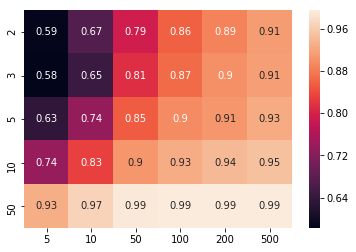

**************************************************CV heat map**************************************************


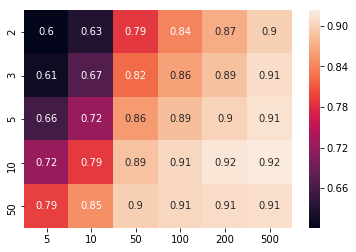

In [8]:
print ('*'*50+'train heat map'+'*'*50)
train_values = pd.DataFrame(data=train_auc_values,index=[2,3,5,10,50],columns=[5,10,50,100,200,500])
ax = sns.heatmap(train_values,annot=True)
plt.show(ax)
print ('*'*50+'CV heat map'+'*'*50)
CV_values = pd.DataFrame(data=cv_scores,index=[2,3,5,10,50],columns=[5,10,50,100,200,500])
ax1 = sns.heatmap(CV_values,annot=True)
plt.show(ax1)

In [9]:
rfc=RandomForestClassifier(n_estimators=200,max_depth=10,class_weight='balanced',n_jobs=-1)
rfc.fit(final_std_data,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

predictions=rfc.predict(standardizing.transform(model.transform(X_test)))
print('accuracy = {0}'.format(rfc.score(standardizing.transform(model.transform(X_test)), y_test)*100))
precision = precision_score(y_test, predictions,pos_label=1)
Recall = recall_score(y_test, predictions,pos_label=1)
f1 = f1_score(y_test, predictions,pos_label=1)
print ('precision = {0}'.format(precision))
print ('Recall={0}'.format(Recall))
print ('f1_score={0}'.format(f1))

accuracy = 87.60333333333334
precision = 0.9607794258174415
Recall=0.8928571428571429
f1_score=0.9255738557905901


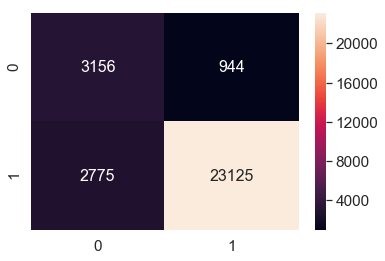

In [11]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,predictions)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

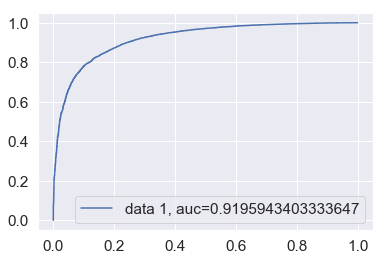

In [12]:
y_pred_proba = rfc.predict_proba(standardizing.transform(model.transform(X_test)))[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba,pos_label=1 )
#auc = roc_auc_score(y_test, y_pred_proba)
auc = np.trapz(tpr,fpr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

### [4.1.1] Feature Importance

In [14]:
feat_names = model.get_feature_names()
feat_names = np.array(feat_names)
# Sort feature importances in descending order
indices = np.argsort(rfc.feature_importances_)[::-1][:25]
print (feat_names[indices])

['not' 'best' 'great' 'would' 'disappoint' 'wast' 'thought' 'love'
 'not buy' 'return' 'product' 'not mend' 'money' 'refund' 'bad' 'away'
 'terribl' 'delici' 'item' 'horribl' 'easi' 'worst' 'perfect' 'would not'
 'keep']


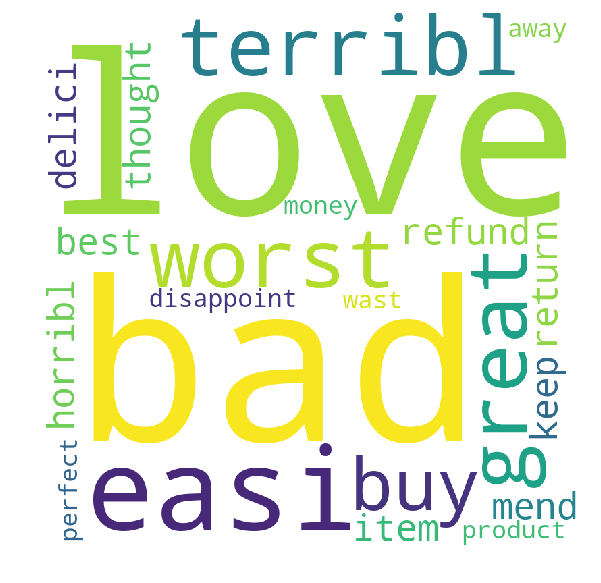

In [15]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white').generate(' '.join(feat_names[indices]))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# [4.2] Random Forest on TFIDF,<font color='red'> SET 2</font>

In [16]:
# split the data set into train and test
tfidf_train, tfidf_test, y_train, y_test = train_test_split(final_data['CleanedText'].values, 
                                                            final_data['Score'].values, 
                                                             test_size=0.3, random_state=0,
                                                             shuffle=False)


In [17]:
vector = TfidfVectorizer(ngram_range = (1,2),min_df=5)
tf_idf_vector = vector.fit_transform(tfidf_train)
standardizing  = StandardScaler(with_mean = False)
tfidf_std_data = standardizing.fit_transform(tf_idf_vector)
tfidf_std_data.shape

(70000, 89447)

In [11]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# creating list for hyperparameter alpha
depth = [2,3,5,10,50]
estimators= [5,10,50,100,200,500]
# empty list that will hold cv scores

cv_scores = []
train_auc_values = []

# perform 10-fold cross validation
for d in depth:
    train = []
    cv = []
    print (d)
    for k in estimators:
        rfc=RandomForestClassifier(n_estimators=k,max_depth=d,class_weight='balanced',n_jobs=-1)
        auc = make_scorer(roc_auc_score,greater_is_better=True,
                             needs_threshold=True)
        auc_scores = cross_val_score(rfc, tfidf_std_data, y_train, cv=10, scoring=auc)
        rfc.fit(tfidf_std_data,y_train)
        y_pred_proba = rfc.predict_proba(tfidf_std_data)[::,1]
        train_auc = roc_auc_score(y_train, y_pred_proba)
        train.append(train_auc)
        cv.append(auc_scores.mean())
    train_auc_values.append(train)
    cv_scores.append(cv)

print ('train data scores')
print (train_auc_values)
print ('*'*50)
print ('CV scores')
print (cv_scores) 

2
3
5
10
50
train data scores
[[0.61086528070511981, 0.68403660409726919, 0.82442561344516507, 0.8528345914717399, 0.897229868449262, 0.90680544692469245], [0.62757488106034032, 0.7061451524108332, 0.86139993558363037, 0.87462087680300005, 0.90541935967277898, 0.91826963951973961], [0.6752380406575379, 0.73740581382481407, 0.8856406301005777, 0.90324639597934175, 0.9191831968692139, 0.92337143084514706], [0.74568275017118635, 0.83859262406832336, 0.92333938003896265, 0.93465659779816379, 0.94479943129887267, 0.9459654170801568], [0.94887468323834201, 0.9824789800517113, 0.99553514977993718, 0.99726589232409868, 0.99732017113295401, 0.99763765039806918]]
**************************************************
CV scores
[[0.5982760900649331, 0.66255171472456453, 0.81557578019725185, 0.85407751759819983, 0.87970785374910587, 0.90132939926291356], [0.6471211979940259, 0.68659800008353933, 0.83079729015734094, 0.86723932205631138, 0.89274356227275364, 0.90387631542324665], [0.66405653674712384, 

**************************************************train heat map**************************************************


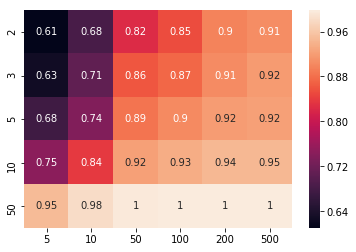

**************************************************CV heat map**************************************************


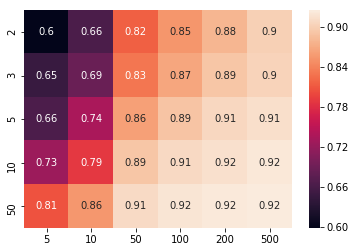

In [12]:
print ('*'*50+'train heat map'+'*'*50)
train_values = pd.DataFrame(data=train_auc_values,index=[2,3,5,10,50],columns=[5,10,50,100,200,500])
ax = sns.heatmap(train_values,annot=True)
plt.show(ax)
print ('*'*50+'CV heat map'+'*'*50)
CV_values = pd.DataFrame(data=cv_scores,index=[2,3,5,10,50],columns=[5,10,50,100,200,500])
ax1 = sns.heatmap(CV_values,annot=True)
plt.show(ax1)

In [18]:
rfc=RandomForestClassifier(n_estimators=200,max_depth=10,class_weight='balanced',n_jobs=-1)
rfc.fit(tfidf_std_data,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

predictions=rfc.predict(standardizing.transform(vector.transform(tfidf_test)))
print('accuracy = {0}'.format(rfc.score(standardizing.transform(vector.transform(tfidf_test)), y_test)*100))
precision = precision_score(y_test, predictions,pos_label=1)
Recall = recall_score(y_test, predictions,pos_label=1)
f1 = f1_score(y_test, predictions,pos_label=1)
print ('precision = {0}'.format(precision))
print ('Recall={0}'.format(Recall))
print ('f1_score={0}'.format(f1))

accuracy = 87.53
precision = 0.9622814703550716
Recall=0.8904633204633204
f1_score=0.9249804479916578


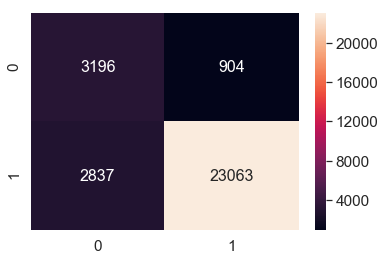

In [20]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,predictions)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

### [4.2.1] Feature Importance

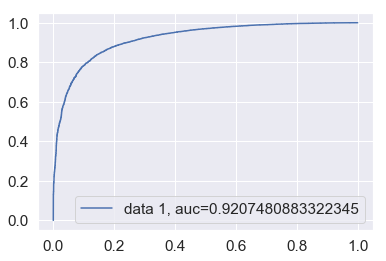

In [21]:
y_pred_proba = rfc.predict_proba(standardizing.transform(vector.transform(tfidf_test)))[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba,pos_label=1 )
#auc = roc_auc_score(y_test, y_pred_proba)
auc = np.trapz(tpr,fpr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [22]:
feat_names = vector.get_feature_names()
feat_names = np.array(feat_names)
# Sort feature importances in descending order
indices = np.argsort(rfc.feature_importances_)[::-1][:25]
print (feat_names[indices])

['not' 'would' 'great' 'best' 'high mend' 'perfect' 'love' 'delici' 'bad'
 'disappoint' 'thought' 'money' 'return' 'worst' 'product' 'wast' 'threw'
 'not mend' 'find' 'easi' 'not buy' 'keep' 'wast money' 'look' 'bought']


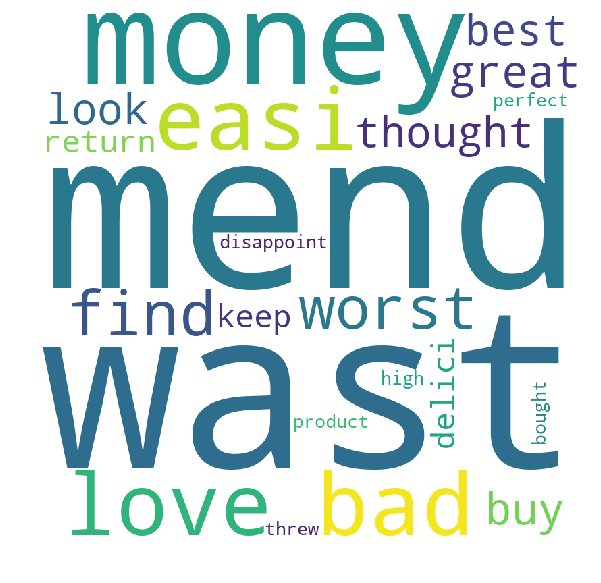

In [23]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white').generate(' '.join(feat_names[indices]))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# [4.3] Random Forest on Avg W2V,<font color='red'> SET 3</font>

In [12]:
import pickle 
with open("avg_w2v_train_data.pkl", "rb") as f:
    avg_w2v_train_data = pickle.load(f)
    
with open("avg_w2v_test_data.pkl", "rb") as f:
    avg_w2v_test_data = pickle.load(f)    
    
with open("y_train.pkl", "rb") as f:
    y_train = pickle.load(f)
    
with open("y_test.pkl", "rb") as f:
    y_test = pickle.load(f)            

In [9]:
standardizing  = StandardScaler(with_mean = False)
avg_w2v_std_train_data = standardizing.fit_transform(avg_w2v_train_data)
avg_w2v_std_train_data.shape

(70000, 300)

In [15]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# creating list for hyperparameter alpha
depth = [2,3,5,10,50]
estimators= [5,10,50,100,200,500]
# empty list that will hold cv scores

cv_scores = []
train_auc_values = []

# perform 10-fold cross validation
for d in depth:
    train = []
    cv = []
    print (d)
    for k in estimators:
        rfc=RandomForestClassifier(n_estimators=k,max_depth=d,class_weight='balanced',n_jobs=-1)
        auc = make_scorer(roc_auc_score,greater_is_better=True,
                             needs_threshold=True)
        auc_scores = cross_val_score(rfc, avg_w2v_std_train_data, y_train, cv=10, scoring=auc)
        rfc.fit(avg_w2v_std_train_data,y_train)
        y_pred_proba = rfc.predict_proba(avg_w2v_std_train_data)[::,1]
        train_auc = roc_auc_score(y_train, y_pred_proba)
        train.append(train_auc)
        cv.append(auc_scores.mean())
    train_auc_values.append(train)
    cv_scores.append(cv)

print ('train data scores')
print (train_auc_values)
print ('*'*50)
print ('CV scores')
print (cv_scores) 

2
3
5
10
50
train data scores
[[0.8041602908515888, 0.81961270993965962, 0.85740548422046392, 0.86294148226144607, 0.85679144418373032, 0.8603496706233047], [0.81537144826567731, 0.84793253444365457, 0.86558429943040816, 0.8676580571634902, 0.87195317500050962, 0.8741432979162076], [0.86551090059984026, 0.8791464177748004, 0.89260786822002358, 0.89479517811601317, 0.89686943668933905, 0.89665325384820505], [0.94387227504800053, 0.95868469157050229, 0.96880793984215818, 0.97060419644735996, 0.97148113604028585, 0.97192660671232833], [0.99680983966975423, 0.99981021322135089, 0.99999764525901258, 0.99999988617267188, 0.99999956151733604, 0.9999999990101972]]
**************************************************
CV scores
[[0.79290402911128965, 0.81669218378421837, 0.84951378904252606, 0.85079316861826104, 0.85164048935061198, 0.85334936418034124], [0.82822690577136238, 0.8416883235530912, 0.86134103736485979, 0.86400690803207214, 0.86537832937511161, 0.86635271109970857], [0.847024726858953

**************************************************train heat map**************************************************


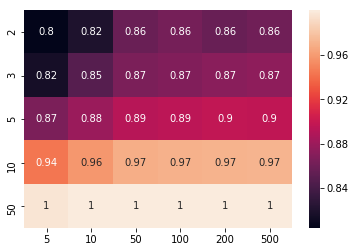

**************************************************CV heat map**************************************************


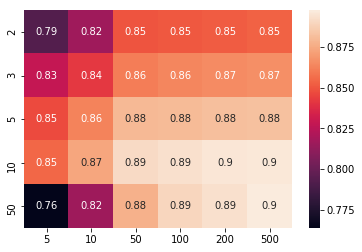

In [16]:
print ('*'*50+'train heat map'+'*'*50)
train_values = pd.DataFrame(data=train_auc_values,index=[2,3,5,10,50],columns=[5,10,50,100,200,500])
ax = sns.heatmap(train_values,annot=True)
plt.show(ax)
print ('*'*50+'CV heat map'+'*'*50)
CV_values = pd.DataFrame(data=cv_scores,index=[2,3,5,10,50],columns=[5,10,50,100,200,500])
ax1 = sns.heatmap(CV_values,annot=True)
plt.show(ax1)

In [10]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(n_estimators=200,max_depth=5,class_weight='balanced',n_jobs=-1)
rfc.fit(avg_w2v_std_train_data,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

predictions=rfc.predict(standardizing.transform(avg_w2v_test_data))
print('accuracy = {0}'.format(rfc.score(standardizing.transform(avg_w2v_test_data), y_test)*100))
precision = precision_score(y_test, predictions,pos_label=1)
Recall = recall_score(y_test, predictions,pos_label=1)
f1 = f1_score(y_test, predictions,pos_label=1)
print ('precision = {0}'.format(precision))
print ('Recall={0}'.format(Recall))
print ('f1_score={0}'.format(f1))

accuracy = 84.43666666666667
precision = 0.9220035778175313
Recall=0.8954826254826255
f1_score=0.9085496033689158


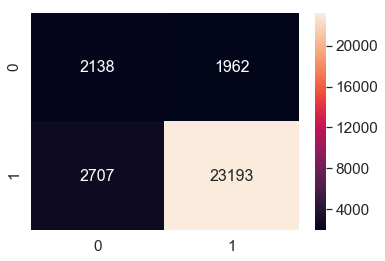

In [14]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,predictions)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

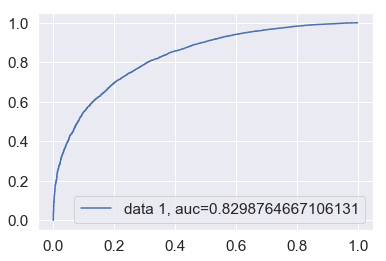

In [16]:
y_pred_proba = rfc.predict_proba(standardizing.transform(avg_w2v_test_data))[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba,pos_label=1 )
#auc = roc_auc_score(y_test, y_pred_proba)
auc = np.trapz(tpr,fpr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# [4.4] Random Forest on TFIDF W2V,<font color='red'> SET 4</font>

In [29]:
import pickle 
with open("tfidf_w2v_train_data.pkl", "rb") as f:
    tfidf_w2v_train_data = pickle.load(f)
    
with open("tfidf_w2v_test_data.pkl", "rb") as f:
    tfidf_w2v_test_data = pickle.load(f)    

In [30]:
standardizing  = StandardScaler(with_mean = False)
tfidf_w2v_std_train_data = standardizing.fit_transform(tfidf_w2v_train_data)
tfidf_w2v_std_train_data.shape

(70000, 300)

In [19]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# creating list for hyperparameter alpha
depth = [2,3,5,10,50]
estimators= [5,10,50,100,200,500]
# empty list that will hold cv scores

cv_scores = []
train_auc_values = []

# perform 10-fold cross validation
for d in depth:
    train = []
    cv = []
    print (d)
    for k in estimators:
        rfc=RandomForestClassifier(n_estimators=k,max_depth=d,class_weight='balanced',n_jobs=-1)
        auc = make_scorer(roc_auc_score,greater_is_better=True,
                             needs_threshold=True)
        auc_scores = cross_val_score(rfc, tfidf_w2v_std_train_data, y_train, cv=10, scoring=auc)
        rfc.fit(tfidf_w2v_std_train_data,y_train)
        y_pred_proba = rfc.predict_proba(tfidf_w2v_std_train_data)[::,1]
        train_auc = roc_auc_score(y_train, y_pred_proba)
        train.append(train_auc)
        cv.append(auc_scores.mean())
    train_auc_values.append(train)
    cv_scores.append(cv)

print ('train data scores')
print (train_auc_values)
print ('*'*50)
print ('CV scores')
print (cv_scores) 

2
3
5
10
50
train data scores
[[0.73793846831175858, 0.76381056578912732, 0.77846501967431125, 0.78395994485610343, 0.78932183162622038, 0.78651430730329996], [0.74884232955248442, 0.77331115086159374, 0.80080048920016211, 0.80026573930057754, 0.80179126107020249, 0.79935187016320453], [0.79601863581015664, 0.81470775872803203, 0.82657413890616094, 0.82920955037017641, 0.83115586900632299, 0.83060256129304677], [0.9143758986172652, 0.93419283062038261, 0.95063471305912228, 0.95244062618095859, 0.95321938821869345, 0.95385872167753383], [0.99532891049826488, 0.99970818632286451, 0.99999848065262054, 0.99999936157715985, 0.99999999901019709, 0.99999998515295729]]
**************************************************
CV scores
[[0.73854256676863628, 0.75462865962283354, 0.77554283757869669, 0.77718230743237027, 0.77962422530605202, 0.78046257842455458], [0.75327724714446831, 0.77304828198928988, 0.78661260957365031, 0.79073924613843261, 0.79120973902660019, 0.79257605298691813], [0.779554751

**************************************************train heat map**************************************************


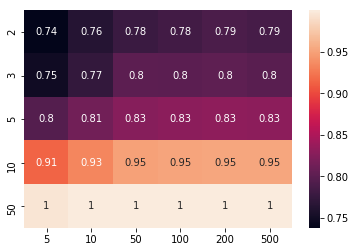

**************************************************CV heat map**************************************************


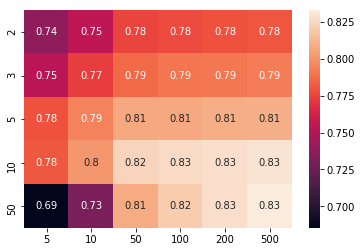

In [20]:
print ('*'*50+'train heat map'+'*'*50)
train_values = pd.DataFrame(data=train_auc_values,index=[2,3,5,10,50],columns=[5,10,50,100,200,500])
ax = sns.heatmap(train_values,annot=True)
plt.show(ax)
print ('*'*50+'CV heat map'+'*'*50)
CV_values = pd.DataFrame(data=cv_scores,index=[2,3,5,10,50],columns=[5,10,50,100,200,500])
ax1 = sns.heatmap(CV_values,annot=True)
plt.show(ax1)

In [50]:
rfc=RandomForestClassifier(n_estimators=500,max_depth=5,class_weight='balanced',n_jobs=-1)
rfc.fit(tfidf_w2v_std_train_data,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=5, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [51]:
predictions=rfc.predict(standardizing.transform(tfidf_w2v_test_data))
print('accuracy = {0}'.format(rfc.score(standardizing.transform(tfidf_w2v_test_data), y_test)*100))
precision = precision_score(y_test, predictions,pos_label=1)
Recall = recall_score(y_test, predictions,pos_label=1)
f1 = f1_score(y_test, predictions,pos_label=1)
print ('precision = {0}'.format(precision))
print ('Recall={0}'.format(Recall))
print ('f1_score={0}'.format(f1))

accuracy = 70.27333333333333
precision = 0.8880003655638823
Recall=0.7503088803088803
f1_score=0.8133684915452872


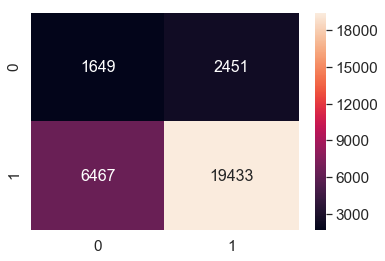

In [52]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sns
result = confusion_matrix(y_test,predictions)
#print(result)
sns.set(font_scale=1.4)#for label size
sns.heatmap(result, annot=True,annot_kws={"size": 16}, fmt='g')

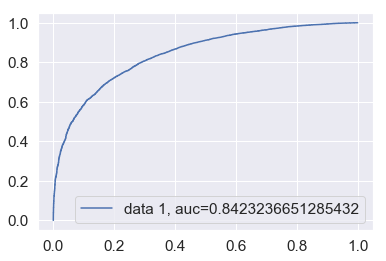

In [53]:
y_pred_proba = rfc.predict_proba(standardizing.transform(tfidf_w2v_test_data))[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba,pos_label=1 )
#auc = roc_auc_score(y_test, y_pred_proba)
auc = np.trapz(tpr,fpr)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# 5) Tabular form of Results

In [17]:
from prettytable import PrettyTable 

x = PrettyTable()

x.field_names = ['Featurization','depth','n_estimators','accuracy','AUC',
                 'precision','recall','f1_score']
x.add_row(['BOW','10','200','87.6','0.9159','0.960','0.8928','0.9255'])
x.add_row(['TFIDF','10','200','87.53','0.9201','0.9622','0.8904','0.925'])
x.add_row(['Avg W2V','5','200','84.45','0.823','0.922','0.8954','0.9085'])
x.add_row(['TFIDF W2V','5','200','70.27','0.8423','0.880','0.7503','0.813'])
print (x)


+---------------+-------+--------------+----------+--------+-----------+--------+----------+
| Featurization | depth | n_estimators | accuracy |  AUC   | precision | recall | f1_score |
+---------------+-------+--------------+----------+--------+-----------+--------+----------+
|      BOW      |   10  |     200      |   87.6   | 0.9159 |   0.960   | 0.8928 |  0.9255  |
|     TFIDF     |   10  |     200      |  87.53   | 0.9201 |   0.9622  | 0.8904 |  0.925   |
|    Avg W2V    |   5   |     200      |  84.45   | 0.823  |   0.922   | 0.8954 |  0.9085  |
|   TFIDF W2V   |   5   |     200      |  70.27   | 0.8423 |   0.880   | 0.7503 |  0.813   |
+---------------+-------+--------------+----------+--------+-----------+--------+----------+


# 6) Conclusion 

1) BOW and TfIdf values are very close 
2) Avg w2v and tfidf w2v are performing poorly, and they are highly skewed towards positive class.
3) Both BOW and TFIDF are best, the difference between the various metrics is very small, we can use both techniques.